# Thanks to [Simplest Implementation of Diffusion Models](https://e-dorigatti.github.io/math/deep%20learning/2023/06/25/diffusion.html)

# Diffusion Models

Diffusion models are a type of generative model primarily used for creating realistic images.    
They involve two main processes: a **forward process** and a **reverse process**.

## Forward Process
This process gradually adds noise to an original data $ x_0$ until it is completely random $ x_T$:

$$
x_{t+1} = \sqrt{1 - \beta_t} x_t + \sqrt{\beta_t} \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, I)
$$

where $ \beta_t$ are variance terms and $ \epsilon_t$ is Gaussian noise.

## Reverse Process
This is the training phase where a neural network learns to reverse the noising process, starting from noise $ x_T$ to reconstruct the original data $ x_0$:
$$
x_{t-1} = \frac{1}{\sqrt{1 - \beta_t}} \left(x_t - \frac{\beta_t}{\sqrt{1 - \beta_t}} \epsilon_\theta(x_t, t)\right)
$$
Here, $ \epsilon_\theta(x_t, t)$ is the noise model predicted by the neural network.

## Sampling
To generate new data, we simulate the reverse process starting from pure noise, progressively transforming it back into coherent data.  
Diffusion models are widely used due to their flexibility and ability to produce high-quality results, particularly in image and sound generation.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import itertools
from tqdm.auto import tqdm

/Users/yoshitakainoue/.pyenv/versions/miniforge3-4.10.1-5/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data generation

- Mixture gaussian
- torch.distributions.Categorical is just the weight for both distribution

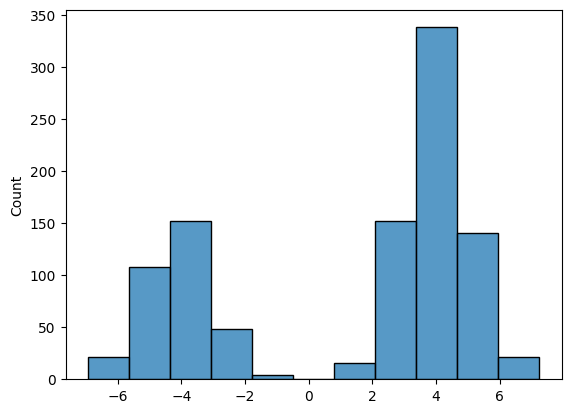

In [2]:
data_distribution = torch.distributions.mixture_same_family.MixtureSameFamily(
    torch.distributions.Categorical(torch.tensor([1, 2])),
    torch.distributions.Normal(torch.tensor([-4., 4.]), torch.tensor([1., 1.]))
)

dataset = data_distribution.sample(torch.Size([1000, 1]))
sns.histplot(dataset[:, 0])
plt.show()

In [3]:
TIME_STEPS = 250
BETA = 0.02

In [4]:
def do_diffusion(data, steps=TIME_STEPS, beta=BETA):
    # Diffuaion Process
    distributions, samples = [None], [data]
    xt = data
    for t in range(steps):
        q = torch.distributions.Normal(
            np.sqrt(1 - beta) * xt,
            np.sqrt(beta)
        )
        xt = q.sample()

        distributions.append(q)
        samples.append(xt)

    return distributions, samples

In [5]:
distributions, samples = do_diffusion(dataset)

In [6]:
dataset.shape

torch.Size([1000, 1])

In [7]:
np.array(samples).shape

(251, 1000, 1)

In [8]:
samples[0].shape

torch.Size([1000, 1])

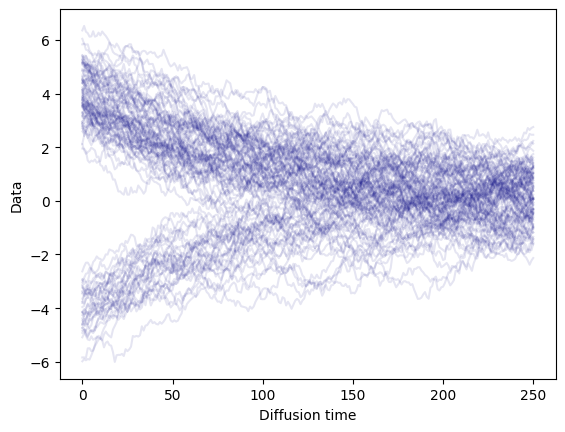

In [9]:
# the evolution of 100 samples diffused over 250 steps

for t in torch.stack(samples)[:, :, 0].T[:100]:
    plt.plot(t, c='navy', alpha=0.1)
plt.xlabel('Diffusion time')
plt.ylabel('Data')
plt.show()

In [10]:
torch.stack(samples)[:, :, 0].T[:100].shape

torch.Size([100, 251])

In [11]:
distributions

[None,
 Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])),
 Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])),
 Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])),
 Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])),
 Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])),
 Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])),
 Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])),
 Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])),
 Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])),
 Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])),
 Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])),
 Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])),
 Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])),
 Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])),
 Normal(loc: torch.Size([1000, 1]), scale: torch.Size([

In [12]:
def compute_loss(forward_distributions, forward_samples, mean_model, var_model):
    # here we compute the loss in equation 3
    # forward = q , reverse = p

    # loss for x(T)
    p = torch.distributions.Normal(
        torch.zeros(forward_samples[0].shape),
        torch.ones(forward_samples[0].shape)
    )
    loss = -p.log_prob(forward_samples[-1]).mean()

    for t in range(1, len(forward_samples)):
        xt = forward_samples[t]         # x(t)
        xprev = forward_samples[t - 1]  # x(t-1)
        q = forward_distributions[t]    # q( x(t) | x(t-1) )

        # normalize t between 0 and 1 and add it as a new column
        # to the inputs of the mu and sigma networks.
        # use current tensor with time vector as an input.
        # xt is a sample at the time point t.
        xin = torch.cat(
            (xt, (t / len(forward_samples)) * torch.ones(xt.shape[0], 1)),
            dim=1
        )
        
        # compute p( x(t-1) | x(t) ) as equation 1
        # calc mean
        mu = mean_model(xin)
        
        # calc variance
        sigma = var_model(xin)
        
        # calc norm distribution for the reverse diffusion, p( x(t-1) | x(t) ) 
        p = torch.distributions.Normal(mu, sigma)

        # add a term to the loss
        # the probability to calculate the how accurately the model can predict x(t-1) from x(t) 
        loss -= torch.mean(p.log_prob(xprev))
        
        #  the probability of how accurately the model can generate x(t) based on x(t-1) 
        loss += torch.mean(q.log_prob(xt))

    return loss / len(forward_samples)

In [13]:
mean_model = torch.nn.Sequential(
    torch.nn.Linear(2, 4), torch.nn.ReLU(), torch.nn.Linear(4, 1)
)

var_model = torch.nn.Sequential(
    torch.nn.Linear(2, 4), torch.nn.ReLU(), torch.nn.Linear(4, 1), torch.nn.Softplus()
)

optim = torch.optim.AdamW(
    itertools.chain(mean_model.parameters(), var_model.parameters()),
    lr=1e-2,
    weight_decay=1e-6,
)

In [14]:
loss_history = []
bar = tqdm(range(1000))
for e in bar:
    forward_distributions, forward_samples = do_diffusion(dataset)

    optim.zero_grad()
    loss = compute_loss(
        forward_distributions, forward_samples, mean_model, var_model
    )
    loss.backward()
    optim.step()

    bar.set_description(f'Loss: {loss.item():.4f}')
    loss_history.append(loss.item())

Loss: 0.0107: 100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:16<00:00, 13.12it/s]


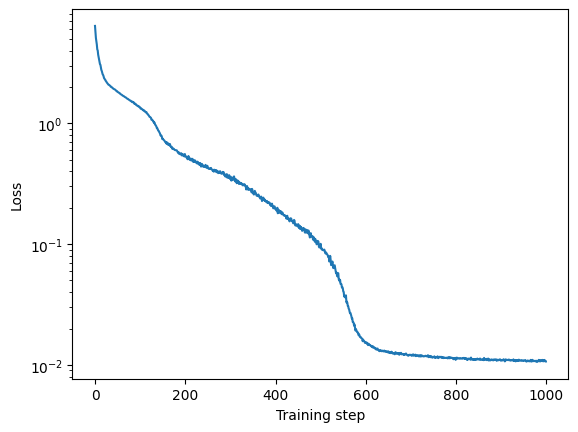

In [15]:
plt.plot(loss_history)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training step')
plt.show()

In [16]:
def sample_reverse(mean_model, var_model, count, steps=TIME_STEPS):
    # Normal distribution
    p = torch.distributions.Normal(torch.zeros(count, 1), torch.ones(count, 1))
    # Get xt's sample
    xt = p.sample()
    # Save first sample
    sample_history = [xt]
    
    for t in range(steps, 0, -1):
        # cat time vector
        xin = torch.cat((xt, t * torch.ones(xt.shape) / steps), dim=1)
        
        # calc normal dist
        p = torch.distributions.Normal(
            mean_model(xin), var_model(xin)
        )
        
        # sampling
        xt = p.sample()
        sample_history.append(xt)
    return sample_history

In [17]:
samps = torch.stack(sample_reverse(mean_model, var_model, 1000))

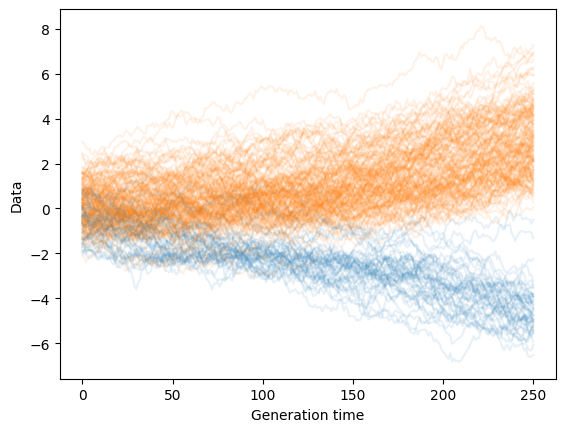

In [18]:
for t in samps[:,:,0].T[:200]:
    plt.plot(t, c='C%d' % int(t[-1] > 0), alpha=0.1)
plt.xlabel('Generation time')
plt.ylabel('Data')
plt.show()

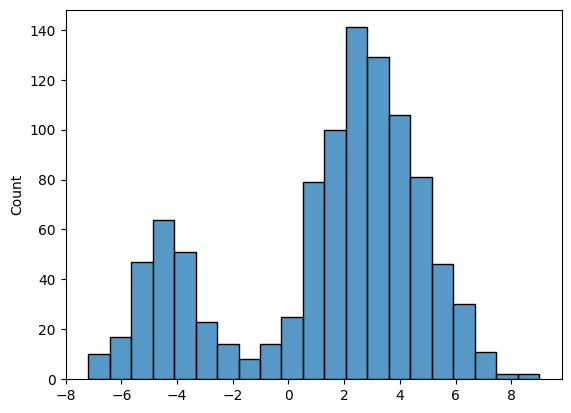

In [19]:
sns.histplot(samps[-1, :, 0])
plt.show()